In [2]:
import geopandas as gpd
import rioxarray as rxr
from rasterstats import zonal_stats
import pandas as pd
import os
import rasterio
from rasterio.mask import mask
import numpy as np
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from rasterio.features import rasterize
from data_utils import best_res_align, align_r1_to_r2
import xarray as xr

In [3]:
laptop_or_server = 1
if laptop_or_server:
    # laptop folder
    folder = "../../_data/p-dengue/"
else:
    # server folder
    folder = "../../../data/lucaratzinger_data/p-dengue/"

valid_admin2 = pd.read_csv(os.path.join(folder, 'valid_admin/valid_admin2.csv'), header=None)[0].tolist()
valid_admin1 = pd.read_csv(os.path.join(folder, 'valid_admin/valid_admin1.csv'), header=None)[0].tolist()
valid_admin2.sort()
valid_admin1.sort()

In [4]:
#### shape data
admin1_shp = gpd.read_file(os.path.join(folder,"shapefiles/admin1/admin1_38.shp"))
admin2_shp = gpd.read_file(os.path.join(folder,"shapefiles/admin2/admin2_38.shp"))

admin1_shp = (admin1_shp[admin1_shp["admin1"].isin(valid_admin1)].sort_values("admin1").reset_index(drop=True))
admin2_shp = (admin2_shp[admin2_shp["admin2"].isin(valid_admin2)].sort_values("admin2").reset_index(drop=True))

print(f'shapefile crs: {admin1_shp.crs}')

#### Population raster
raster_pop = {year :  rxr.open_rasterio(os.path.join(folder, f'raster_pop/landscan-global-{year}.tif'), masked=True) for year in range(2015,2025)}
print(f'raster_pop crs: {raster_pop[2015].rio.crs}')

#### Urban raster (GHSL GHS-SMOD)
raster_urbanisation = rxr.open_rasterio(os.path.join(folder, 'raster_urbanisation/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V2_0.tif'), masked=True)

raster_urbanisation_binary = raster_urbanisation.copy()
urban_classes = [21, 22, 23, 30]
raster_urbanisation_binary = raster_urbanisation_binary.where(~raster_urbanisation_binary.isin(urban_classes), other=1)
rural_classes = [10, 11, 12, 13]
raster_urbanisation_binary = raster_urbanisation_binary.where(~raster_urbanisation_binary.isin(rural_classes), other=0)
raster_urbanisation_binary = raster_urbanisation_binary.where((raster_urbanisation_binary == 0) | (raster_urbanisation_binary == 1))
print(f'raster_urbanisation crs: {raster_urbanisation.rio.crs}')
raster_urbanisation = raster_urbanisation.rio.reproject(admin1_shp.crs)
raster_urbanisation_binary = raster_urbanisation_binary.rio.reproject(admin1_shp.crs)
print(f'raster_urbanisation crs projected to: {raster_urbanisation.rio.crs}')

#### Surveillance raster (Ahyoung Lim et al. Nature Medicine)
raster_surveillance = rxr.open_rasterio(os.path.join(folder, 'raster_surveillance/Surveillance_map_wmean.tif'), masked=True)
# EPSG:4326
raster_surveillance = raster_surveillance.rio.write_crs("EPSG:4326")
print(f'raster_surveillance crs: {raster_surveillance.rio.crs}')

shapefile crs: EPSG:4326
raster_pop crs: EPSG:4326
raster_urbanisation crs: ESRI:54009
raster_urbanisation crs projected to: EPSG:4326
raster_surveillance crs: EPSG:4326


In [5]:
# buffered region bounds
merged = admin1_shp.union_all()
merged_buffered = gpd.GeoDataFrame(geometry=[merged], crs=admin1_shp.crs)
merged_buffered["geometry"] = (merged_buffered.to_crs("EPSG:3857").buffer(20_000).to_crs("EPSG:4326"))
region_bounds_buffered = merged_buffered.bounds.iloc[0, :].to_list()

In [6]:
#### Population raster
raster_pop = {year :  raster_pop[year].squeeze().rio.clip_box(minx=region_bounds_buffered[0], miny=region_bounds_buffered[1],
                                                   maxx=region_bounds_buffered[2], maxy=region_bounds_buffered[3]) for year in range(2015,2025)}


#### Urban raster (GHSL GHS-SMOD)
raster_urbanisation_binary = raster_urbanisation_binary.squeeze().rio.clip_box(minx=region_bounds_buffered[0], miny=region_bounds_buffered[1],
                                                   maxx=region_bounds_buffered[2], maxy=region_bounds_buffered[3])

#### Surveillance raster (Ahyoung Lim et al. Nature Medicine)
raster_surveillance = raster_surveillance.squeeze().rio.clip_box(minx=region_bounds_buffered[0], miny=region_bounds_buffered[1],
                                                   maxx=region_bounds_buffered[2], maxy=region_bounds_buffered[3])

---

### climate variables

In [86]:
weather_folder = os.path.join(folder, "weather_statistics-(reanalysis-era5-land)")

In [80]:
tp_monthly_24hmean = {}
tp_monthly_24hmax = {}

pixel_monthly_statistics = {}

tp_monthly_24hmax_aligned = {}
tp_monthly_24hmean_aligned = {}

pixel_monthly_statistics_aligned = {}

stat_names = ["tp_24hmean", "tp_24hmax"]

---
#### checking incremental or cumulative

looking at the rainfall data, it is cumulative so depending on how we calculate statistics we need to make it incremental. For average rainfall we either take the mean of the incremental data at all steps, or the mean of the daily total (last step of each day), which scales by a factor of 24. The other statistics is 24h max precipitation for which we take a rolling sum so we need to use incremental data.

In [37]:
year = 2015
tp = xr.open_dataset(os.path.join(weather_folder, f"tp/tp_{year}.grib"),engine="cfgrib")
tp = tp.isel(time=slice(1, None))
tp = tp['tp']
tp = tp.rio.write_crs("EPSG:4326")
tp_inc = xr.concat(
    [
        tp.isel(step=0),
        tp.diff("step")
    ],
    dim="step"
)

# make sure step coords are preserved
tp_inc = tp_inc.assign_coords(step=tp.step)

In [ ]:
tp_pt = tp.sel(latitude=tp.latitude.values[100],
               longitude=tp.longitude.values[100],
               method="nearest")

tp_pt_inc = tp_inc.sel(latitude=tp.latitude.values[100],
               longitude=tp.longitude.values[100],
               method="nearest")

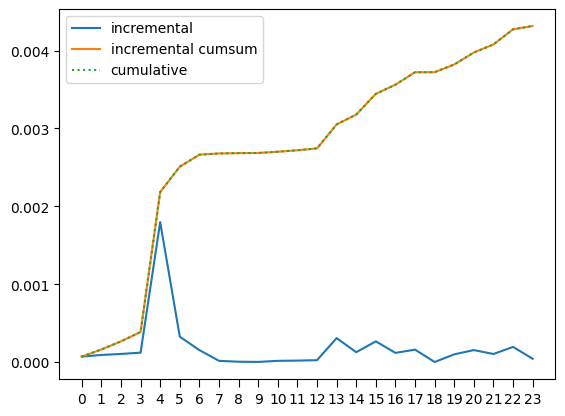

In [43]:
ax = plt.gca()

x = np.arange(tp_pt.isel(time=slice(90, 91)).sizes["step"])
ax.set_xticks(x)

plt.plot(tp_pt_inc.isel(time=slice(90, 91)).values[0], label='incremental')
plt.plot(np.cumsum(tp_pt_inc.isel(time=slice(90, 91)).values[0]), label='incremental cumsum')
plt.plot(tp_pt.isel(time=slice(90, 91)).values[0], label='cumulative', linestyle=':')

plt.tick_params(axis='x', length=6)
plt.legend()
plt.show()

---

In [77]:
year=2015
tp = xr.open_dataset(os.path.join(weather_folder, f"tp/tp_{year}.grib"),engine="cfgrib")
tp = tp.isel(time=slice(1, None))
tp = tp['tp']
tp = tp.rio.write_crs("EPSG:4326")
tp_inc = xr.concat(
    [
        tp.isel(step=0),
        tp.diff("step")
    ],
    dim="step"
)
# make sure step coords are preserved
tp_inc = tp_inc.assign_coords(step=tp.step)

In [78]:
tp_inc_stacked = tp_inc.stack(sample=("time", "step"))

tp_inc_stacked = (
    tp_inc_stacked
    .reset_index("sample", drop=True)          # remove MultiIndex cleanly
    .rename(sample="time")                     # we have a time dimension
    .assign_coords(time=tp_inc_stacked.valid_time.values)
    .drop_vars("valid_time")
)
tp_inc_shifted = tp_inc_stacked.assign_coords(
    time=tp_inc_stacked.time - np.timedelta64(1, "h")
)

In [81]:
# Daily totals
daily = tp_inc_shifted.resample(time="1D").sum()
# Monthly mean daily rainfall
tp_monthly_24hmean[year] = daily.groupby("time.month").mean()

# Monthly max 24h rainfall
tp_monthly_24hmax[year] = (
    tp_inc_shifted
    .rolling(time=24, min_periods=24)
    .sum()
    .groupby("time.month")
    .max()
)

In [84]:
tp_monthly_24hmean[year] = tp_monthly_24hmean[year].transpose(
    "month", "latitude", "longitude"
)

tp_monthly_24hmax[year] = tp_monthly_24hmax[year].transpose(
    "month", "latitude", "longitude"
)

---

In [87]:
tp_monthly_24hmean = {}
tp_monthly_24hmax = {}

pixel_monthly_statistics = {}

tp_monthly_24hmax_aligned = {}
tp_monthly_24hmean_aligned = {}

pixel_monthly_statistics_aligned = {}

stat_names = ["tp_24hmean", "tp_24hmax"]

In [88]:
for year in range(2015, 2016):
    # read in data
    tp = xr.open_dataset(os.path.join(weather_folder, f"tp/tp_{year}.grib"),engine="cfgrib")
    tp = tp.isel(time=slice(1, None))
    tp = tp['tp']
    tp = tp.rio.write_crs("EPSG:4326")
    tp_inc = xr.concat([tp.isel(step=0), tp.diff("step")], dim="step")
    # make sure step coords are preserved
    tp_inc = tp_inc.assign_coords(step=tp.step)
    tp_inc_stacked = tp_inc.stack(sample=("time", "step"))
    tp_inc_stacked = (
        tp_inc_stacked
        .reset_index("sample", drop=True)          # remove MultiIndex cleanly
        .rename(sample="time")                     # we have a time dimension
        .assign_coords(time=tp_inc_stacked.valid_time.values)
        .drop_vars("valid_time")
    )
    # shift by 1 hour
    tp_inc_shifted = tp_inc_stacked.assign_coords(
        time=tp_inc_stacked.time - np.timedelta64(1, "h")
    )

    # calculating statistics
    # Daily totals
    daily = tp_inc_shifted.resample(time="1D").sum()
    # Monthly mean daily rainfall
    tp_monthly_24hmean[year] = daily.groupby("time.month").mean()

    # Monthly max 24h rainfall
    tp_monthly_24hmax[year] = (
        tp_inc_shifted
        .rolling(time=24, min_periods=24)
        .sum()
        .groupby("time.month")
        .max()
    )

    # transpose for alignment
    tp_monthly_24hmean[year] = tp_monthly_24hmean[year].transpose(
        "month", "latitude", "longitude")
    tp_monthly_24hmax[year] = tp_monthly_24hmax[year].transpose(
        "month", "latitude", "longitude")
    
    # alignment
    # all nearest because non land values are nan and will bleed inside when interpolating
    align_methods = {"tp_24hmean":  "nearest",
                        "tp_24hmax":  "nearest"}

    _, tp_monthly_24hmean_aligned[year] = best_res_align(raster_pop[year], '',
                                            tp_monthly_24hmean[year], align_methods['tp_24hmean'],
                                            region_bounds_buffered = region_bounds_buffered,
                                            shape_crs = admin1_shp.crs)
    _, tp_monthly_24hmax_aligned[year] = best_res_align(raster_pop[year], '',
                                            tp_monthly_24hmax[year], align_methods['tp_24hmax'],
                                            region_bounds_buffered = region_bounds_buffered,
                                            shape_crs = admin1_shp.crs)

In [89]:
# saving
pixel_monthly_statistics = {"tp_24hmean" : tp_monthly_24hmean,
                            "tp_24hmax" : tp_monthly_24hmax}
pixel_monthly_statistics_aligned = {"tp_24hmean" : tp_monthly_24hmean_aligned,
                                    "tp_24hmax" : tp_monthly_24hmax_aligned}

___

In [ ]:
for year in range(2015,2016):
    # read in climate data datasets
    # tp to incremental
    tp = xr.open_dataset(os.path.join(weather_folder, f"tp/tp_{year}.grib"),engine="cfgrib")
    tp = tp.isel(time=slice(1, None))
    tp = tp['tp']
    tp = tp.rio.write_crs("EPSG:4326")
    tp_inc = xr.concat(
        [
            tp.isel(step=0),
            tp.diff("step")
        ],
        dim="step"
    )
    # make sure step coords are preserved
    tp_inc = tp_inc.assign_coords(step=tp.step)

    # calculate monthly pixel statistics
    ###

    tp['time'] = pd.to_datetime(tp['time'].values)
    tp_24h = tp.rolling(time=24, min_periods=24).sum()
    tp_monthly_max24h = tp_24h.groupby("time.month").max(dim="time")
    # tp_monthly_max24h[year] = tp.groupby('time.month').max(dim=['time']).sum(dim=['step'])
    
    ###
    # all nearest because non land values are nan and will bleed inside when interpolating
    align_methods = {"tp_24hmean":  "nearest",
                     "tp_24hmax":  "nearest"}

    _, tp_monthly_24hmean_aligned[year] = best_res_align(raster_pop[year], '',
                                            tp_monthly_24hmean[year], align_methods['tp_24hmean'],
                                            region_bounds_buffered = region_bounds_buffered,
                                            shape_crs = admin1_shp.crs)
    _, tp_monthly_24hmax_aligned[year] = best_res_align(raster_pop[year], '',
                                            tp_monthly_24hmax[year], align_methods['tp_24hmax'],
                                            region_bounds_buffered = region_bounds_buffered,
                                            shape_crs = admin1_shp.crs)

# saving
pixel_monthly_statistics = {"tp_24hmean" : tp_monthly_24hmean,
                            "tp_24hmax" : tp_monthly_24hmax}
pixel_monthly_statistics_aligned = {"tp_24hmean" : tp_monthly_24hmean_aligned,
                                    "tp_24hmax" : tp_monthly_24hmax_aligned}

### Masking and averaging

In [51]:
admin1_dict = {}
admin2_dict = {}
for stat_name in stat_names[:]:
    print(stat_name)
    for year in range(2015,2025):
        print(year)
        pixel_statistic_aligned = pixel_monthly_statistics_aligned[stat_name][year]

        # admin1
        statistic_unweighted_records_1 = []
        statistic_pop_weighted_records_1 = []

        for i, row in enumerate(admin1_shp.itertuples()):
            print(row.admin1)
            mask = rasterize([(row.geometry, 1)],
                                out_shape=pixel_statistic_aligned.shape[-2:],
                                transform=pixel_statistic_aligned.rio.transform(),
                                fill=0,
                                all_touched=True,
                                dtype="uint8"
                                ).astype(bool)
            statistic_values = np.where(mask, pixel_statistic_aligned.values, np.nan)
            pop_values = np.where(mask, raster_pop[year].values, np.nan)
            pop_values_b = np.broadcast_to(pop_values, statistic_values.shape)
            if np.all(np.isnan(statistic_values)):
                print('all nan')
                continue
            unweighted_mean_per_month = np.nanmean(statistic_values, axis=(1,2))
            statistic_unweighted_records_1.append(unweighted_mean_per_month)

            valid = (~np.isnan(statistic_values)) & (~np.isnan(pop_values_b))
            weighted_sum = np.nansum(statistic_values * pop_values_b * valid, axis=(1,2))
            pop_sum = np.nansum(pop_values_b * valid, axis=(1,2))
            
            pop_weighted_mean_per_month = weighted_sum / pop_sum
            statistic_pop_weighted_records_1.append(pop_weighted_mean_per_month)

            for month in range(1, statistic_values.shape[0]+1):
                key = (row.admin1, year, month)
                if key not in admin1_dict:
                    admin1_dict[key] = {
                        "admin1": row.admin1,
                        "year": year,
                        "month": month
                    }
                admin1_dict[key][f"{stat_name}_unweighted"] = unweighted_mean_per_month[month-1]
                admin1_dict[key][f"{stat_name}_pop_weighted"] = pop_weighted_mean_per_month[month-1]

        # admin2
        statistic_unweighted_records_2 = []
        statistic_pop_weighted_records_2 = []

        for i, row in enumerate(admin2_shp.itertuples()):
            print(row.admin2)
            mask = rasterize([(row.geometry, 1)],
                                out_shape=pixel_statistic_aligned.shape[-2:],
                                transform=pixel_statistic_aligned.rio.transform(),
                                fill=0,
                                all_touched=True,
                                dtype="uint8"
                                ).astype(bool)
            statistic_values = np.where(mask, pixel_statistic_aligned.values, np.nan)
            pop_values = np.where(mask, raster_pop[year].values, np.nan)
            pop_values_b = np.broadcast_to(pop_values, statistic_values.shape)
            if np.all(np.isnan(statistic_values)):
                print('all nan')
                continue
            unweighted_mean_per_month = np.nanmean(statistic_values, axis=(1,2))
            statistic_unweighted_records_2.append(unweighted_mean_per_month)

            valid = (~np.isnan(statistic_values)) & (~np.isnan(pop_values_b))
            weighted_sum = np.nansum(statistic_values * pop_values_b * valid, axis=(1,2))
            pop_sum = np.nansum(pop_values_b * valid, axis=(1,2))
            
            pop_weighted_mean_per_month = weighted_sum / pop_sum
            statistic_pop_weighted_records_2.append(pop_weighted_mean_per_month)

            for month in range(1, statistic_values.shape[0]+1):
                key = (row.admin2, year, month)
                if key not in admin2_dict:
                    admin2_dict[key] = {
                        "admin2": row.admin2,
                        "year": year,
                        "month": month
                    }
                admin2_dict[key][f"{stat_name}_unweighted"] = unweighted_mean_per_month[month-1]
                admin2_dict[key][f"{stat_name}_pop_weighted"] = pop_weighted_mean_per_month[month-1]

t2m_mean
2015
ACEH
BALI
BANTEN
BENGKULU
DAERAH ISTIMEWA YOGYAKARTA
DKI JAKARTA
GORONTALO
JAMBI
JAWA BARAT
JAWA TENGAH
JAWA TIMUR
KALIMANTAN BARAT
KALIMANTAN SELATAN
KALIMANTAN TENGAH
KALIMANTAN TIMUR
KALIMANTAN UTARA
KEPULAUAN BANGKA BELITUNG
KEPULAUAN RIAU
LAMPUNG
MALUKU
MALUKU UTARA
NUSA TENGGARA BARAT
NUSA TENGGARA TIMUR
PAPUA
PAPUA BARAT
PAPUA BARAT DAYA
PAPUA PEGUNUNGAN
PAPUA SELATAN
PAPUA TENGAH
RIAU
SULAWESI BARAT
SULAWESI SELATAN
SULAWESI TENGAH
SULAWESI TENGGARA
SULAWESI UTARA
SUMATRA BARAT
SUMATRA SELATAN
SUMATRA UTARA
ACEH BARAT
ACEH BARAT DAYA
ACEH BESAR
ACEH JAYA
ACEH SELATAN
ACEH SINGKIL
ACEH TAMIANG
ACEH TENGAH
ACEH TENGGARA
ACEH TIMUR
ACEH UTARA
AGAM
ALOR
ASAHAN
ASMAT
BADUNG
BALANGAN
BANDUNG
BANDUNG BARAT
BANGGAI
BANGGAI KEPULAUAN
BANGGAI LAUT
BANGKA
BANGKA BARAT
BANGKA SELATAN
BANGKA TENGAH
BANGKALAN
BANGLI
BANJAR
BANJARNEGARA
BANTAENG
BANTUL
BANYU ASIN
BANYUMAS
BANYUWANGI
BARITO KUALA
BARITO SELATAN
BARITO TIMUR
BARITO UTARA
BARRU
BATANG
BATANG HARI
BATU BARA
BEKASI
B

In [52]:
# Convert to DataFrame
admin1_records = list(admin1_dict.values())
df_admin1_statistics = pd.DataFrame(admin1_records)
df_admin1_statistics = df_admin1_statistics.sort_values(by=["admin1", "year", "month"]).reset_index(drop=True)

admin2_records = list(admin2_dict.values())
df_admin2_statistics = pd.DataFrame(admin2_records)
df_admin2_statistics = df_admin2_statistics.sort_values(by=["admin2", "year", "month"]).reset_index(drop=True)

In [53]:
df_admin2_statistics

,admin2,year,month,t2m_mean_unweighted,t2m_mean_pop_weighted,t2m_min_unweighted,t2m_min_pop_weighted,t2m_max_unweighted,t2m_max_pop_weighted,tp_mean_unweighted,tp_mean_pop_weighted,rh_mean_unweighted,rh_mean_pop_weighted
0,ACEH BARAT,2015,1,296.553192,298.113488,292.452057,294.097140,302.009125,302.825969,0.005766,0.004416,89.093109,87.167199
1,ACEH BARAT,2015,2,296.917328,298.429072,291.295868,293.372377,302.661713,303.363930,0.005092,0.004271,86.445282,85.063198
2,ACEH BARAT,2015,3,297.053772,298.567195,292.830322,294.606322,302.866943,303.605977,0.004616,0.003547,88.586975,87.120348
3,ACEH BARAT,2015,4,296.811218,298.293407,293.230194,294.852081,302.896729,303.613153,0.008693,0.007106,91.291878,89.598911
4,ACEH BARAT,2015,5,297.676849,299.290881,293.623840,295.463444,303.104401,303.967454,0.003813,0.002801,88.033737,85.696828
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61435,YALIMO,2024,8,294.672638,294.702880,290.136902,289.959379,299.825897,299.376732,0.004374,0.003554,86.708893,85.686131
61436,YALIMO,2024,9,294.606079,294.658601,289.825562,289.764754,300.661285,300.381228,0.006410,0.005784,87.778755,86.769433
61437,YALIMO,2024,10,294.584778,294.678387,290.242371,290.284942,300.648193,300.368047,0.008298,0.007836,87.763924,86.740003
61438,YALIMO,2024,11,294.789398,294.851689,289.383331,289.130681,301.835602,301.330760,0.006114,0.005306,87.147903,86.362742


In [ ]:
# df_admin1_statistics.to_csv(os.path.join(folder, 'admin_year_month_climate_statistics/admin1_year_month_climate_statistics.csv'), index=False)
# df_admin2_statistics.to_csv(os.path.join(folder, 'admin_year_month_climate_statistics/admin2_year_month_climate_statistics.csv'), index=False)

---